# Subspace learning experiments

Test recurrent gain control against Oja's rule for principal subspace learning.

In [1]:
import os
import multiprocessing
from pathlib import Path
from typing import Optional
print(f'cpus: {multiprocessing.cpu_count()}')

# set to OMP_NUM_THREADS=1 to avoid multithreading conflicts
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import scipy as sp
import seaborn as sns
from tqdm import tqdm

import frame_whitening as fw
import frame_whitening.data as fwd

cpus: 128


In [16]:
def compute_subspace_error(V: npt.NDArray[np.float64]) -> float:
    tmp = V @ np.linalg.inv(V.T @ V) @ V.T
    return np.linalg.norm(tmp - np.diag((1, 1, 0)))**2

def subspace_learning(
    x_dim: int, 
    s_dim: int, 
    step_oja: float, 
    relative_speed: float, 
    iters: int = 1000,
    seed: Optional[int] = None,
    frame_type: str = 'full',
    ) -> npt.NDArray[np.float64]:

    rng = np.random.default_rng(seed)
    step_size = relative_speed * step_oja

    Lss = np.diag(np.sqrt((5, 2, 1)))

    # init weights from s to x
    V = rng.standard_normal((x_dim, s_dim))

    if frame_type == 'full':
        W = fw.get_mercedes_frame()
    else:
        W = np.eye(x_dim)

    K = W.shape[1]
    W = fw.normalize_frame(W)

    err = []
    In = np.eye(x_dim)
    g = np.ones(K)

    for _ in range(iters):
        err.append(compute_subspace_error(V.T))

        s = rng.standard_normal(s_dim) @ Lss.T

        if frame_type == 'full':
            WGW = W @ (g[:, None] * W.T)  # equiv to W@diag(g)@W.T
            M_inv = np.linalg.inv(In + WGW)

            y = M_inv @ V @ s
            z = W.T @ y
            g += step_size * (z**2 - 1)
            V += step_oja * (np.outer(y, s) - np.diag(y * y) @ V)
        else:
            y = V @ s
            V += step_oja * (np.outer(y, s) - np.diag(y * y) @ V)
            V /= np.linalg.norm(V, axis=0)


    return err

def simulate_many(
    step_oja: float,
    relative_speed: float,
    n_repeats: int, 
    frame_type: str = 'full',
) -> npt.NDArray[np.float64]:
    """Run all simulations in parallel."""
    s_dim = 3
    x_dim = 2

    iters = int(1E3)

    with multiprocessing.Pool() as pool:
        all_errors = []
        pbar = tqdm(total=n_repeats)
        for errors in pool.starmap(
            subspace_learning, 
            [(x_dim, s_dim, step_oja, relative_speed, iters, i, frame_type) for i in range(n_repeats)]):
            all_errors.append(errors)
            pbar.update(1)
    all_errors = np.array(all_errors)
    return all_errors

n_repeats = 50

relative_speed = 20.
step_oja_g = 5E-3
all_errors_g_full = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    frame_type='full'
    )

all_errors_m = simulate_many(
    step_oja_g,
    relative_speed, 
    n_repeats, 
    frame_type='none'
    )


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 188.76it/s]


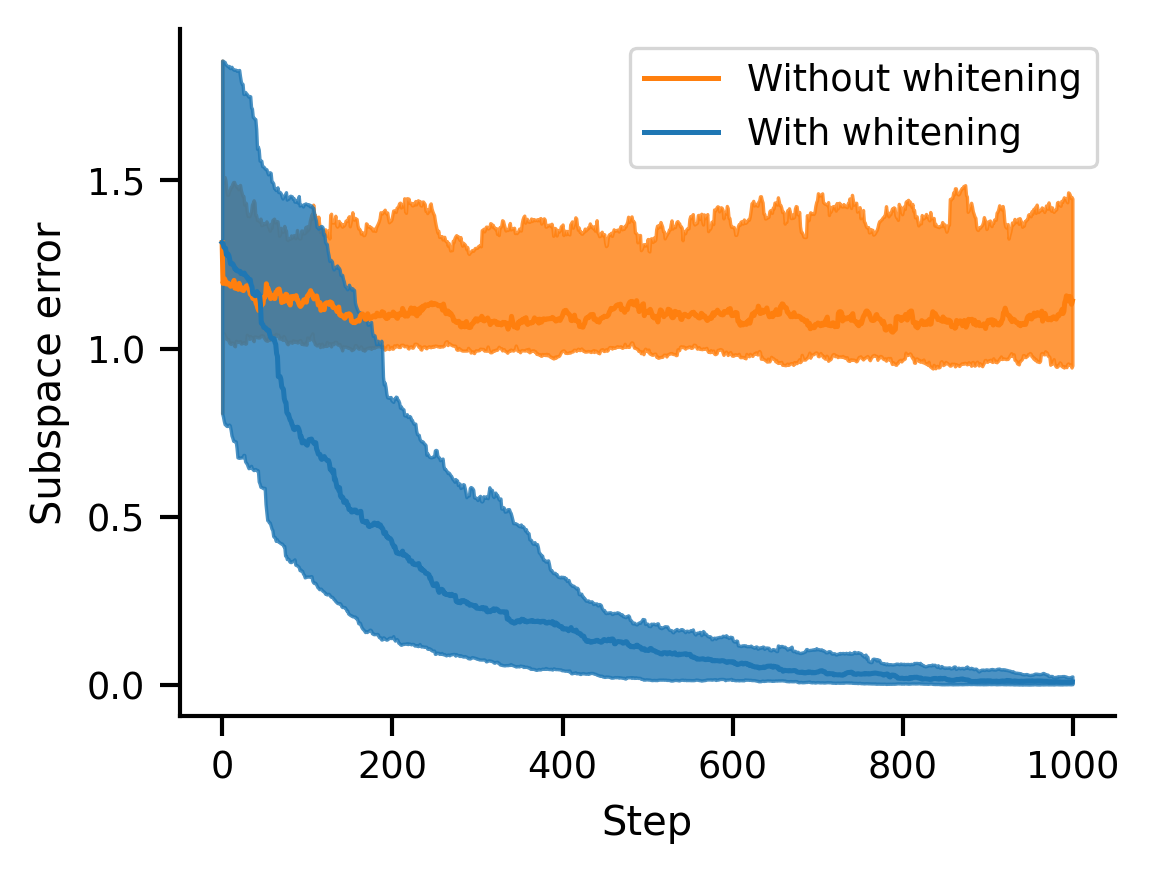

In [24]:
def plot_shaded_error(all_errors, ax, label, color):
    mu = np.median(all_errors, axis=0)
    sig_lo, sig_hi = np.quantile(all_errors, [.25, .75], axis=0)
    x = np.arange(len(mu))
    ax.fill_between(x, sig_lo, sig_hi, alpha=.8, color=color)
    ax.plot(x, mu, label=label, color=color)

with sns.plotting_context('paper'):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3), sharey='all', sharex='all', dpi=300)
    plot_shaded_error(all_errors_m, ax, label='Without whitening', color='C1')
    plot_shaded_error(all_errors_g_full, ax, label='With whitening', color='C0')
    ax.set(
        ylabel='Subspace error', 
        # ylabel=r'$\Vert {\bf V (V^\top V)^{-1} V^\top} - diag([1,1,0])\Vert_F^2$', 
        xlabel='Step',
        )
    ax.legend()
    sns.despine()
    fig.tight_layout()